# ROI detection with Deep Learning
Notebook used to test ROI detection using PyTorch

In [1]:
%matplotlib inline

import os, sys, time, shutil
import random
import ipywidgets as widgets
from ipywidgets import interact

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from skimage import io
from PIL import Image
from sklearn.model_selection import train_test_split

import torch
import torchvision
from torch.utils import data

from utils_common.image import imread_to_float, to_npint, overlay_mask
from utils_data import normalize_range, get_all_dataloaders, get_filenames
from utils_loss import get_crop_loss, get_dice_metric, get_crop_dice_metric
from utils_model import weights_initialization, CustomUNet
from utils_train import train
from utils_test import predict, predict_stack, evaluate, show_sample

seed = 1
random.seed(seed)
np.random.seed(seed*10 + 1234)
torch.manual_seed(seed*100 + 4321)

# Use GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)

%load_ext autoreload
%autoreload 2

Device: cuda:0


## Parameters
Hyperparameters, folder names, etc.

In [2]:
n_epochs = 2
batch_size = 32
learning_rate = 0.001
diceC_scale = 4.0 # scale of the cropping (w.r.t. ROI's bounding box) for the dice coef.

synth_data = False
synth_ratio = 0.5 # ratio of synthetic data vs. real data
only_synth = False # If True, will use only the synthetic data (and all of it, at the opposite of ratio=1)

use_masks = False # If True, will use masks for the loss

input_channels = "R" # Channel to use as input
u_depth = 4
out1_channels = 16

model_name = "test"
model_dir = "models/"
data_dir = "/data/talabot/dataset_cv-annotated/"

## Data loading
Create dataloaders, and build data-related constants.

In [3]:
# Create transforms that pad images to multiple of 2 ** u_depth if needed
def pad_transform(image):
    factor = 2 ** u_depth
    if image.ndim == 3:
        height, width = image.shape[1:]
    elif image.ndim == 2:
        height, width = image.shape
        
    # Do nothing if image has correct shape
    if height % factor == 0 and width % factor == 0:
        return image
    
    height_pad = (factor - height % factor) * bool(height % factor)
    width_pad = (factor - width % factor) * bool(width % factor)
    padding = [(int(np.floor(height_pad/2)), int(np.ceil(height_pad/2))), 
               (int(np.floor(width_pad/2)), int(np.ceil(width_pad/2)))]
    if image.ndim == 3:
        return np.pad(image, [(0,0)] + padding, 'constant')
    elif image.ndim == 2:
        return np.pad(image, padding, 'constant')

# Create dataloaders
dataloaders = get_all_dataloaders(
    data_dir,
    batch_size, 
    input_channels = input_channels,
    test_dataloader = True,
    synthetic_data = synth_data, synthetic_ratio = synth_ratio,
    synthetic_only = only_synth, use_masks=use_masks,
    train_transform = lambda img: normalize_range(pad_transform(img)), train_target_transform = pad_transform,
    eval_transform = lambda img: normalize_range(pad_transform(img)), eval_target_transform = pad_transform
)

N_TRAIN = len(dataloaders["train"].dataset)
N_VALID = len(dataloaders["valid"].dataset)
N_TEST = len(dataloaders["test"].dataset)
print("%d images:" % (N_TRAIN + N_VALID + N_TEST))
print("%d to train" % N_TRAIN, end="")
if only_synth:
    print(" (of synthetic data only).")
elif synth_data:
    if synth_ratio is None:
        print(" (with synthetic data)")
    else:
        print(" (with %d%% of synthetic data)" % (synth_ratio * 100))
else:
    print("")
print("%d to validation" % N_VALID)
print("%d to test" % N_TEST)
if use_masks:
    print("Use of masks is enabled.")

# Compute class weights (as pixel imbalance) takes ~90s for 78 stacks
pos_count = 0
neg_count = 0
for filename in dataloaders["train"].dataset.y_filenames:
    y = io.imread(filename)
    pos_count += (y == 255).sum()
    neg_count += (y == 0).sum()
pos_weight = torch.tensor(neg_count / pos_count).to(device)
# Following has been pre-computed
# pos_weight = torch.tensor(120.0).to(device)
if pos_count != 0 and neg_count != 0:
    print("{} ROI pixels, and {} background --> {:f} positive weighting.".format(
        pos_count, neg_count, pos_weight.item()))
else:
    print("{:.3f} positive weighting (pre-computed).".format(pos_weight.item()))

28800 images:
18000 to train
6000 to validation
4800 to test
11126882 ROI pixels, and 873609118 background --> 78.513382 positive weighting.


## Model definition
Define model, loss, metrics, and optimizer.

In [4]:
model = CustomUNet(len(input_channels), u_depth=u_depth, 
                   out1_channels=out1_channels, batchnorm=True, device=device)
print(model)

# Save the "architecture" of the model by copy/pasting the class definition file
os.makedirs(os.path.join(model_dir, model_name), exist_ok=True)
shutil.copy("utils_model.py", os.path.join(model_dir, model_name, "utils_model_save.py"))

loss_fn = torch.nn.BCEWithLogitsLoss(reduction='elementwise_mean', pos_weight=pos_weight)
crop_loss = get_crop_loss(loss_fn, scale=diceC_scale, device=device)

dice_metric = get_dice_metric()
diceC_metric = get_crop_dice_metric(scale=diceC_scale)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

CustomUNet(
  (activation): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (convs): ModuleList(
    (0): UNetConv(
      (activation): ReLU()
      (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): UNetConv(
      (activation): ReLU()
      (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): UNetConv(
      (activation): ReLU()
      (co

## Training

In [5]:
best_model, history = train(model,
                            dataloaders,
                            loss_fn,
                            optimizer,
                            n_epochs,
                            metrics = {"lossC%.1f"%diceC_scale: crop_loss, 
                                       "dice": dice_metric, "diC%.1f"%diceC_scale: diceC_metric},
                            criterion_metric = "dice",
                            model_dir = os.path.join(model_dir, model_name),
                            replace_dir = True,
                            verbose = 1)

Epoch 1/2  (Elapsed time: 0h 00min 00s)
---------------------------------------
Batch (over 563): 1...56...112...168...224...280...336...392...448...504...560...
Train loss: 0.207621 - lossC4.0: 0.450544 - dice: 0.668042 - diC4.0: 0.678443
Valid loss: 0.068538 - lossC4.0: 0.354883 - dice: 0.782856 - diC4.0: 0.741225

Epoch 2/2  (Elapsed time: 0h 05min 29s)
---------------------------------------
Batch (over 563): 1...56...112...168...224...280...336...392...448...504...560...
Train loss: 0.024692 - lossC4.0: 0.175101 - dice: 0.777761 - diC4.0: 0.759692
Valid loss: 0.058785 - lossC4.0: 0.379645 - dice: 0.754261 - diC4.0: 0.719896

Training took 0h 10min 27s.
Best validation dice = 0.783 at epoch 1.
According validation loss = 0.069 - lossC4.0 = 0.355 - diC4.0 = 0.741


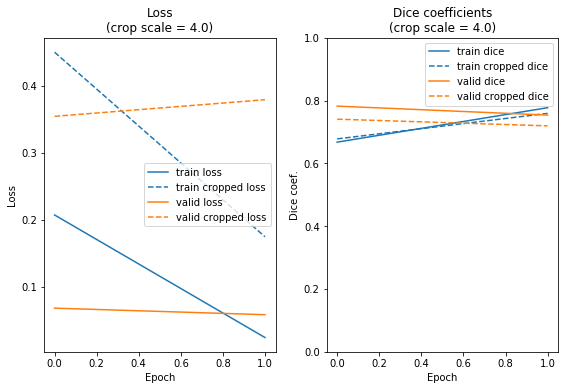

In [6]:
fig = plt.figure(figsize=(8,6))
plt.subplot(121)
plt.title("Loss\n(crop scale = %.1f)" % diceC_scale)
plt.plot(history["epoch"], history["loss"], color="C0")
plt.plot(history["epoch"], history["lossC%.1f" % diceC_scale], "--", color="C0")
plt.plot(history["epoch"], history["val_loss"], color="C1")
plt.plot(history["epoch"], history["val_lossC%.1f" % diceC_scale], "--", color="C1")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train loss", "train cropped loss", "valid loss", "valid cropped loss"])
plt.subplot(122)
plt.title("Dice coefficients\n(crop scale = %.1f)" % diceC_scale)
plt.plot(history["epoch"], history["dice"], color="C0")
plt.plot(history["epoch"], history["diC%.1f" % diceC_scale], "--", color="C0")
plt.plot(history["epoch"], history["val_dice"], color="C1")
plt.plot(history["epoch"], history["val_diC%.1f" % diceC_scale], "--", color="C1")
plt.xlabel("Epoch")
plt.ylabel("Dice coef.")
plt.ylim(0,1)
plt.legend(["train dice", "train cropped dice", "valid dice", "valid cropped dice"])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Testing
Test and visualize best model on valid/test data. Note that this is for debugging purposes: you should use the test data only at the very end! Otherwise, just use validation data.

In [6]:
# Test over test data
test_metrics = evaluate(best_model, dataloaders["valid"], 
                        {"loss": lambda x,y,z: loss_fn(x[z], y[z]), 
                         "lossC%.1f"%diceC_scale: crop_loss, 
                        "dice": dice_metric, "diC%.1f"%diceC_scale: diceC_metric})
print("Test loss = {}\nDice coef = {}\nDice C{:.1f} = {}".format(
    test_metrics["loss"], test_metrics["dice"], diceC_scale, test_metrics["diC%.1f"%diceC_scale]))

Test loss = 0.19361134506265323
Dice coef = 0.773693072795868
Dice C4.0 = 0.7397592301368714


Image   4108 (/data/talabot/dataset_cv-annotated/validation/MDN1-1_image_MDN1_tdTom-GC6s_005/rgb_frames/rgb_0508.png): 
lossC4.0 = 5.418881 - dice = 0.646259 - diC4.0 = 0.614731 - 
Image   3088 (/data/talabot/dataset_cv-annotated/validation/MAN-4_imaging_MAN1_fly3_007/rgb_frames/rgb_0088.png): 
lossC4.0 = 0.100670 - dice = 0.689730 - diC4.0 = 0.755436 - 
Image    415 (/data/talabot/dataset_cv-annotated/validation/MAN-2_image_MAN1_tdTom-GC6s_fly2_014/rgb_frames/rgb_0415.png): 
lossC4.0 = 7.015744 - dice = 0.888889 - diC4.0 = 0.803286 - 
Image   1186 (/data/talabot/dataset_cv-annotated/validation/MAN-2_image_MAN1_tdTom-GC6s_fly2_019/rgb_frames/rgb_0586.png): 
lossC4.0 = 0.136760 - dice = 0.873810 - diC4.0 = 0.846875 - 


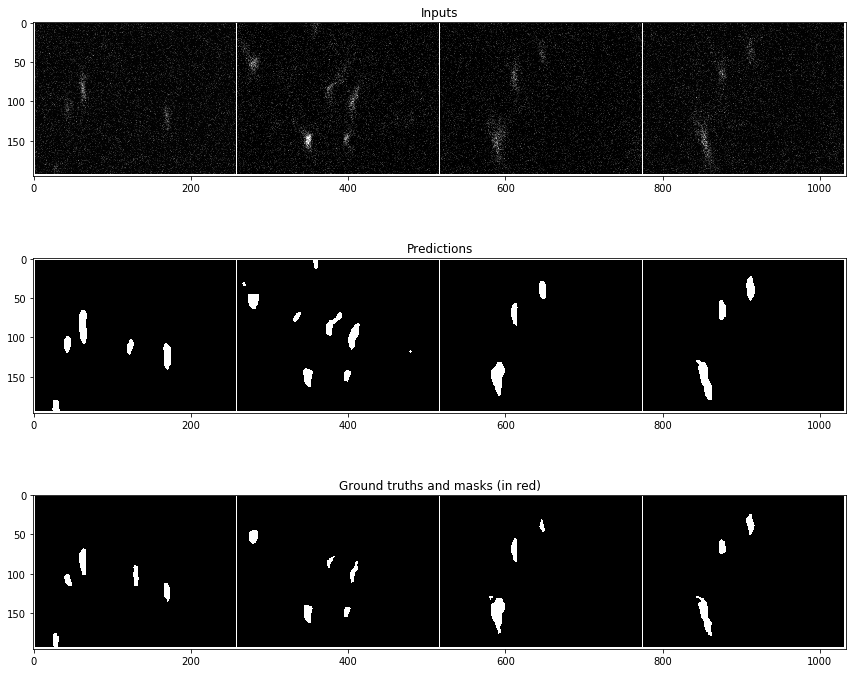

In [12]:
show_sample(best_model, dataloaders["valid"], n_samples=4, 
            post_processing = lambda preds: torch.tensor(torch.sigmoid(preds) > 0.5, dtype=torch.float32), 
            metrics = ({"lossC%.1f"%diceC_scale: crop_loss, 
                        "dice": dice_metric, "diC%.1f"%diceC_scale: diceC_metric}))

Image   5296 (/data/talabot/dataset_cv-annotated/validation/MDN1-4_imaging_MDN1_fly1_004/rgb_frames/rgb_0496.png): 
lossC4.0 = 0.391208 - dice = 0.710425 - diC4.0 = 0.747485 - 
Image    890 (/data/talabot/dataset_cv-annotated/validation/MAN-2_image_MAN1_tdTom-GC6s_fly2_019/rgb_frames/rgb_0290.png): 
lossC4.0 = 0.234051 - dice = 0.818126 - diC4.0 = 0.829431 - 
Image   4601 (/data/talabot/dataset_cv-annotated/validation/MDN1-1_image_MDN1_tdTom-GC6s_010/rgb_frames/rgb_0401.png): 
lossC4.0 = 1.245035 - dice = 0.701360 - diC4.0 = 0.545873 - 
Image   1404 (/data/talabot/dataset_cv-annotated/validation/MAN-2_image_MAN1_tdTom-GC6s_fly2_022/rgb_frames/rgb_0204.png): 
lossC4.0 = 0.221855 - dice = 0.910606 - diC4.0 = 0.902643 - 


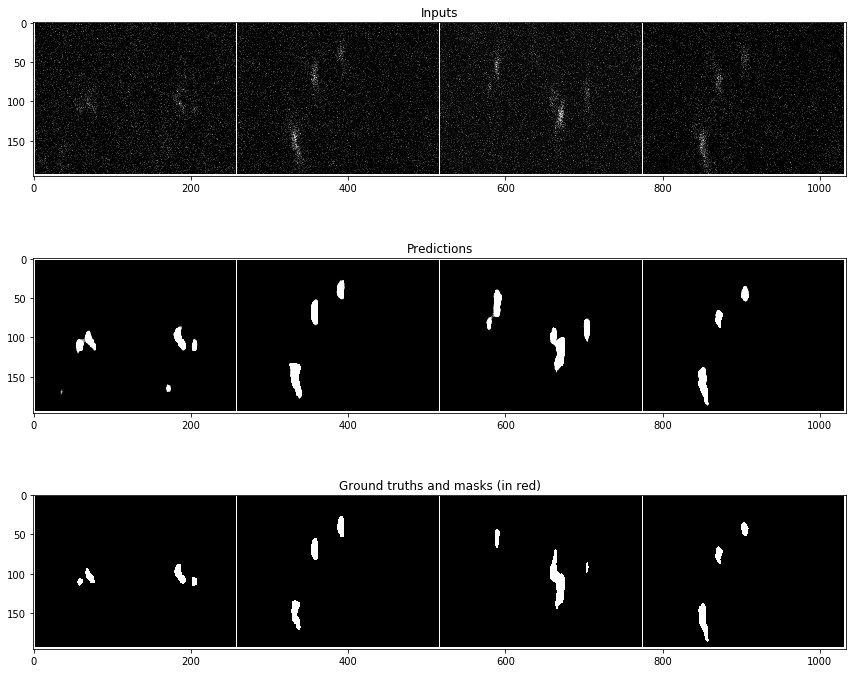

In [8]:
show_sample(best_model, dataloaders["valid"], n_samples=4, 
            post_processing = None, 
            metrics = ({"lossC%.1f"%diceC_scale: crop_loss, 
                        "dice": dice_metric, "diC%.1f"%diceC_scale: diceC_metric}))

### Test on a full stack

In [ ]:
exp_name = "/home/user/talabot/workdir/20180716_R85A02-tdTomGC6fopt-fly4/R85A02-tdTomGC6fopt-fly4-001/"
# exp_name = "/data/talabot/dataset_cv-annotated/validation_fail/A1_S47-3_fly1_S47_tdTom-GC6s_fly3_013/"
rgb_stack = imread_to_float(os.path.join(exp_name, "RGB.tif"))
try:
    seg_stack = imread_to_float(os.path.join(exp_name, "seg_ROI.tif"))
except FileNotFoundError:
    seg_stack = None
channels = {"R": rgb_stack[...,0], "G": rgb_stack[...,1], "B": rgb_stack[...,2]}
stack = np.stack([channels[channel] for channel in input_channels], axis=1)
if use_masks:
    try:
        mask_stack = imread_to_float(os.path.join(exp_name, "mask.tif"))
    except FileNotFoundError:
        mask_stack = np.zeros_like(seg_stack)
else:
    mask_stack = np.zeros_like(seg_stack)
mask_stack = 1 - mask_stack

### Optional normalization ###
stack = normalize_range(stack)

start_predict = time.time()
predictions = predict_stack(best_model, stack, batch_size, input_channels=input_channels)
print("Prediction took %.1fs." % (time.time() - start_predict))

if seg_stack is not None:
    print("dice = %.3f" % dice_metric(predictions[:len(seg_stack)], torch.from_numpy(seg_stack),
                                      torch.from_numpy(mask_stack[:len(seg_stack)])))
    print("cropped dice = %.3f" % diceC_metric(predictions[:len(seg_stack)], torch.from_numpy(seg_stack),
                                      torch.from_numpy(mask_stack[:len(seg_stack)])))

predictions = torch.sigmoid(predictions)
@interact(num = widgets.IntSlider(min=0, max=len(rgb_stack) - 1, description='image:'))
def plot_stack_img(num=0):
    plt.figure(figsize=(12,12))
    plt.subplot(221)
    plt.title("RGB data")
    plt.imshow(rgb_stack[num])
    plt.subplot(222)
    plt.title("Input")
    if input_channels == "R":
        plt.imshow(rgb_stack[num,...,0], vmin=0, vmax=1, cmap="gray")
    elif input_channels == "RG":
        plt.imshow(rgb_stack[num], vmin=0, vmax=1)
    plt.subplot(223)
    plt.title("Prediction (max = %.1f)" % predictions[num].max())
    plt.imshow(predictions[num], vmin=0, vmax=1, cmap="gray")
    plt.subplot(224)
    plt.title("Binary reduction")
    plt.imshow(predictions[num] > 0.5, vmin=0, vmax=1, cmap="gray")
    plt.tight_layout()
    plt.show()
    
    if seg_stack is not None and num < len(seg_stack):
        cmap = matplotlib.cm.get_cmap("viridis")
        cmap.set_under([1,0,0])
        plt.figure(figsize=(12,6))
        plt.subplot(121)
        plt.title("Target")
        plt.imshow(overlay_mask(seg_stack[num], 1-mask_stack[num]), cmap="gray")
        plt.subplot(122)
        plt.title("Overlap")
        plt.imshow(2 * (predictions[num] > 0.5).cpu().numpy() - seg_stack[num], vmin=0, cmap=cmap)
        plt.tight_layout()
        plt.show()

Prediction took 0.9s.
dice = 0.501
cropped dice = 0.627


interactive(children=(IntSlider(value=0, description='image:', max=146), Output()), _dom_classes=('widget-inte…